In [5]:
## torchsummary and torchview are not a part of requirements.txt but are usful for visualizing model architecture
!pip install torchsummary
!pip install torchview

In [19]:
import random
import os
import glob
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision

from torch import nn
from torch.utils.data import Dataset, DataLoader

from torchsummary import summary
from torchview import draw_graph

import albumentations as A
from albumentations.pytorch import ToTensorV2

from PIL import Image
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

set_seed()

# The model was trained on kaggle environment thus the paths are coresponding to kaggle Input/ directory

DATASET_PATH = "/kaggle/input/lgg-mri-segmentation/kaggle_3m/*/*_mask.tif"
SAVE_MODEL_PARH = "/kaggle/working/model.pth"

warnings.filterwarnings("ignore")
plt.style.use("dark_background")

In [14]:
image_masks = glob.glob(DATASET_PATH)
image_paths = [file_path.replace("_mask", '') for file_path in image_masks]

In [15]:
def labels(mask_path):
    label = []
    for mask in mask_path:
        img = Image.open(mask)
        label.append(1) if np.array(img).sum() > 0 else label.append(0)
    return label
mask_labels = labels(image_masks)

In [16]:
df = pd.DataFrame({
        'image_path': image_paths,
        'mask_path' : image_masks,
        'label' : mask_labels
    })

In [17]:
df.head()

,image_path,mask_path,label
0,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
1,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
2,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1
3,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1
4,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1


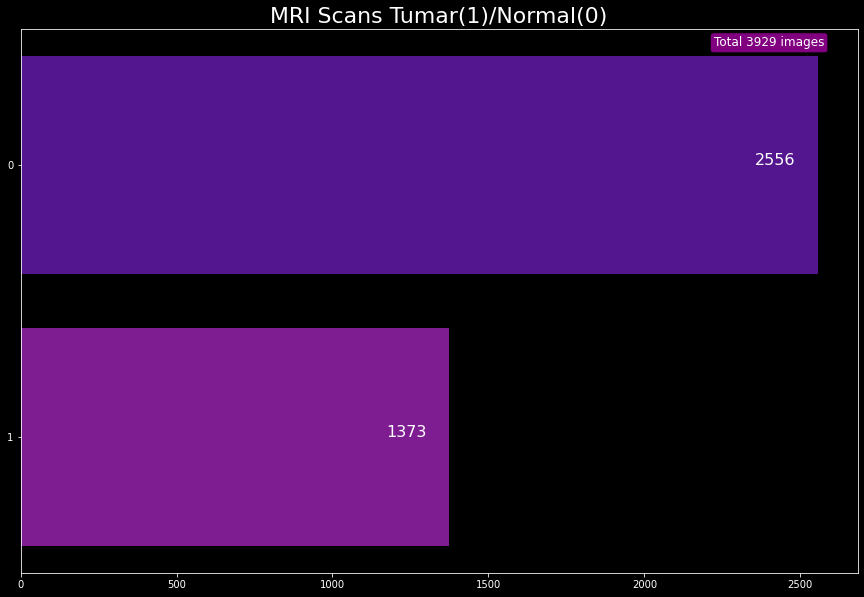

In [20]:
fig = plt.figure(figsize=(15, 10))
plt.title('MRI Scans Tumar(1)/Normal(0)', fontsize=22);

categories = ["0", "1"]

count_0 = df["label"].eq(0).sum()
count_1 = df["label"].eq(1).sum()

values = [count_0, count_1]
text_params = {
    'x'       : 2400,
    'y'       : -0.45,
    's'       : f"Total {len(df)} images", 
    'size'    : 12,
    'color'   : "white",
    'ha'      : "center", 
    'va'      : "center",
    'bbox'    : dict(boxstyle="round", fc=("purple"),ec=("black"))
}
plt.text(**text_params);
bar_plot=sns.barplot(x=values, y=categories,palette=sns.color_palette("plasma"))
for i, v in enumerate(values):
    bar_plot.text(v-200, i, str(v), color="white", size=16)
plt.show()

In [21]:
train_transforms = A.Compose([
    A.Resize(224, 224, p=1.0),
    A.RandomBrightnessContrast(p=0.2),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    ToTensorV2(),
])

# Only reshape inference data
val_transforms = A.Compose([
    A.Resize(224, 224, p=1.0),
    ToTensorV2(),
])

In [22]:
class MRIDataset(Dataset):
    def __init__(self, paths, transform):
        self.paths = paths
        self.transform = transform
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        image_path, mask_path = self.paths.iloc[idx]
        image = Image.open(image_path)
        mask = Image.open(mask_path)
#         label = labels(mask_path)
        image = np.array(image).astype(np.float32) / 255.
        mask = np.array(mask).astype(np.float32) / 255.
        
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            return transformed['image'], transformed['mask'].unsqueeze(0)
        else:
            transformed = ToTensorV2()(image=image, mask=mask)
            return transformed['image'], transformed['mask'].unsqueeze(0)

In [23]:
# splitting the dataset
train_x, val_x, train_y, val_y = train_test_split(df.drop('label',axis=1), df.label,test_size=0.3)
val_x , test_x, val_y, test_y = train_test_split(val_x, val_y, test_size = 0.2)

train_data = MRIDataset(train_x, train_transforms)
val_data = MRIDataset(val_x, val_transforms)
test_data = MRIDataset(test_x[test_y == 1], val_transforms)

In [24]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=8, shuffle=True)

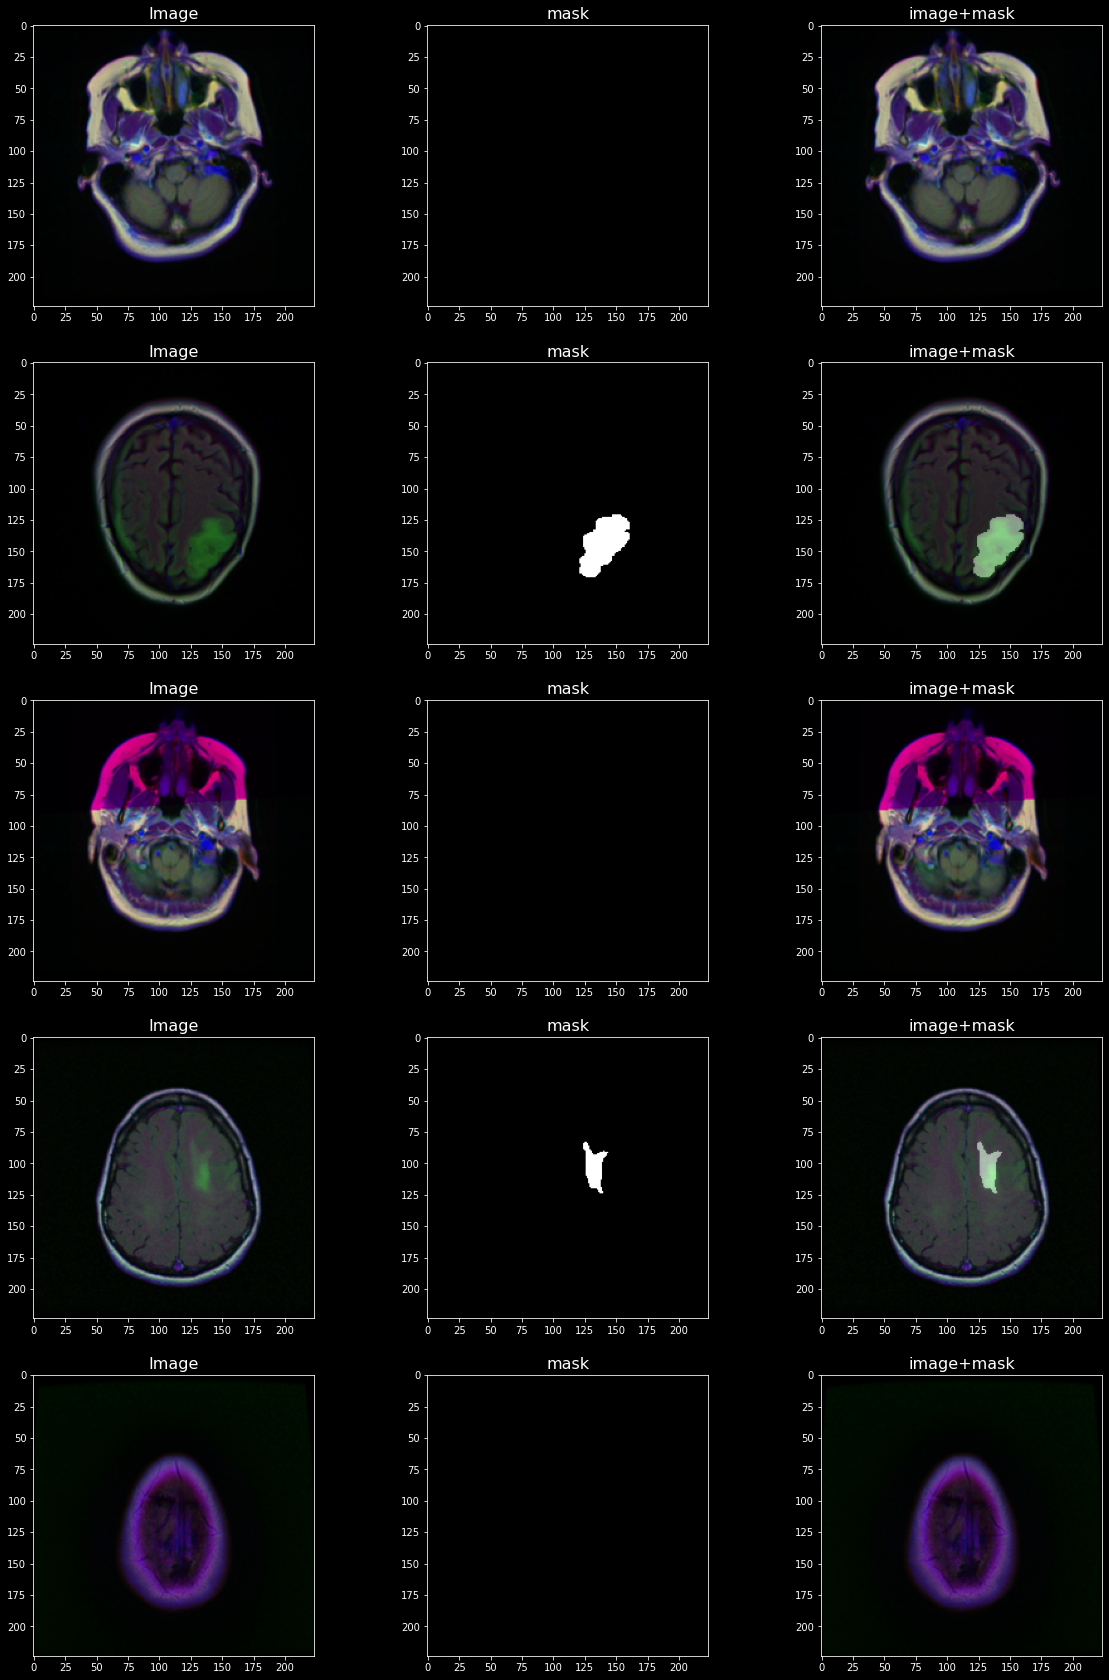

In [25]:
fig = plt.figure(figsize=(20,30))
fig.tight_layout()
count = 5
for i, (x, y) in enumerate(train_loader):
#     print(y.shape)
    if i == count:
        break
    img, mask =  x[0], y[0]
    
    img = img.permute(1 , 2 , 0)
    mask = mask.permute(1, 2, 0)
    plt.subplot(count, 3 , (3*i)+1)
#     plt.axis('off')
    
    plt.imshow(img)
    plt.title("Image", size=16)
    plt.subplot(count, 3, 3*i+2)
#     plt.axis('off')
    plt.imshow(mask, cmap='gray')
    plt.title("mask", size=16)
    
    mask_img = img + mask*0.4
    plt.subplot(count, 3, 3*i+3)
#     plt.axis('off')
    plt.imshow(mask_img)
    plt.title("image+mask", size=16)

In [26]:
import torch
import torch.nn as nn


class DownSampling(nn.Module):
    
    def __init__(self, in_channels, out_channels, max_pool):
        """
        DownSampling block in the U-Net architecture.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            max_pool (bool): Whether to use max pooling.
        """
        super(DownSampling, self).__init__()
        self.max_pool = max_pool
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.batchnorm2d = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.maxpool2d = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        x = self.relu(self.batchnorm2d(x))
        skip_connection = x
        
        if self.max_pool:
            next_layer = self.maxpool2d(x)
        else:
            return x
        return next_layer, skip_connection

class UpSampling(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        UpSampling block in the U-Net architecture.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
        """
        super(UpSampling, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels=out_channels, kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.batchnorm = nn.BatchNorm2d(out_channels)

    def forward(self, x, prev_skip):
        x = self.up(x)
        x = torch.cat((x, prev_skip), dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        next_layer = self.relu(self.batchnorm(x))
        return next_layer

class UNet(nn.Module):
    
    """
        U-Net architecture.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            features (list): List of feature sizes for downsampling and upsampling.
    """
    def __init__(self, in_channels, out_channels, features):
        super(UNet, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()

        for feature in features:
            self.downs.append(DownSampling(in_channels, feature, True))
            in_channels = feature

        for feature in reversed(features):
            self.ups.append(UpSampling(2 * feature, feature))

        self.bottleneck = DownSampling(features[-1], 2 * features[-1], False)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x, skip_connection = down(x)
            skip_connections.append(skip_connection)
        skip_connections = skip_connections[::-1]
        x = self.bottleneck(x)
        for i, up in enumerate(self.ups):
            x = up(x, skip_connections[i])

        return self.final_conv(x)


In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [28]:
model = UNet(in_channels=3, out_channels=1, features=[64, 128, 256, 512]).to(device)

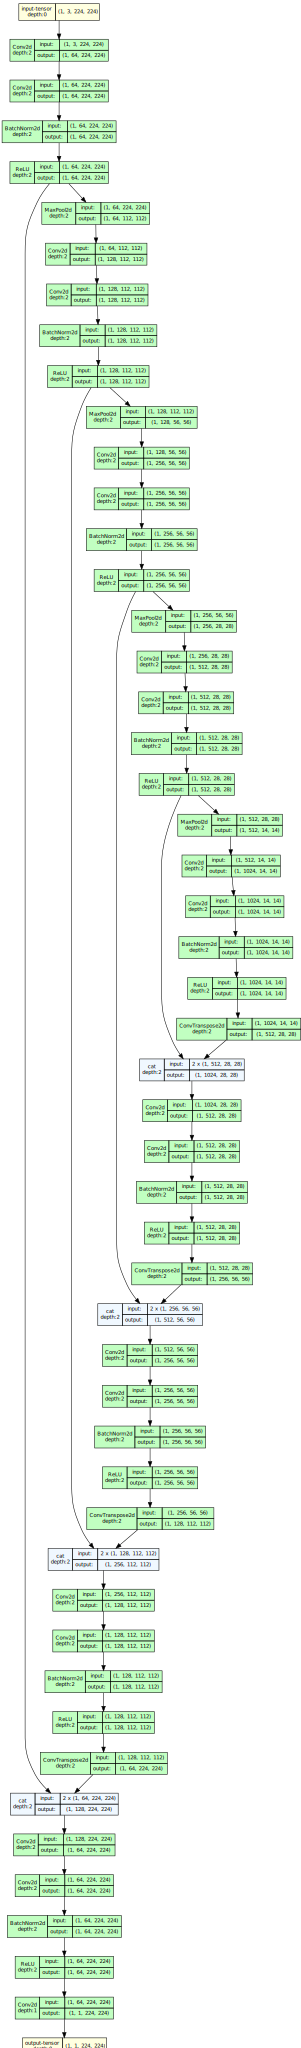

In [29]:
dummy_input = torch.rand(1, 3, 224, 224).type(torch.FloatTensor).to(device)
model_graph = draw_graph(model, input_data=dummy_input)
model_graph.visual_graph

In [30]:
loss_fn = nn.BCEWithLogitsLoss()
# Define Optimizer
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-4)

In [31]:
def train_epoch(dataloader):
    Loss = 0
    Dice_score = 0
    for x, y in tqdm(dataloader):
        x = x.type(torch.cuda.FloatTensor)
        y = y.type(torch.cuda.FloatTensor)
        
        predict = model(x)
        loss = loss_fn(predict, y)
        Loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        predict = torch.sigmoid(predict)
        predict = (predict > 0.5).float() 
        
        dice_score = (2 * (y*predict).sum() + 1e-8)/((y+predict).sum() + 1e-8)
        
        Dice_score += dice_score.cpu().item()
        
    Loss /= len(dataloader)
    Dice_score /= len(dataloader)
    
    return Loss , Dice_score

def valid_epoch(dataloader):
    Loss = 0
    Dice_score = 0
    model.eval()
    with torch.no_grad():
        
        for x, y in tqdm(dataloader):
            x = x.type(torch.cuda.FloatTensor)
            y = y.type(torch.cuda.FloatTensor)

            predict = model(x)
            loss = loss_fn(predict, y)
            Loss += loss.item()
            
            predict = torch.sigmoid(predict)
            predict = (predict > 0.5).float() 

            dice_score = (2 * (y*predict).sum() + 1e-8)/((y+predict).sum() + 1e-8)

            Dice_score += dice_score.cpu().item()

        Loss /= len(dataloader)
        Dice_score /= len(dataloader)
    
    return Loss , Dice_score

In [32]:
EPOCHS = 50
summary = {
        'train_loss' : [],
        'train_dice' : [],
        'valid_loss' : [],
        'valid_dice' : []
    }
dice_score = 0
besst_model = UNet(3,1,[64, 128, 256, 512]).to(device)
for epoch in range(EPOCHS):
    
    print(f"Epoch: {epoch+1}/{EPOCHS}")
    train_loss , train_dice = train_epoch(train_loader)
    val_loss, val_dice = valid_epoch(val_loader)
    print("Train Loss: {}    Dice Score: {}".format(train_loss, train_dice))
    print("Valid Loss: {}    Dice Score: {}".format(val_loss, val_dice))
    
    if val_dice > dice_score:
        dice_score = val_dice
        torch.save(model, "unet_model.pth")
        best_model = model
        
    summary["train_loss"].append(train_loss)
    summary["valid_loss"].append(val_loss)
    summary["train_dice"].append(train_dice)
    summary["valid_dice"].append(val_dice)

Epoch: 1/50


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 0.4101677713699119    Dice Score: 0.3604180353130539
Valid Loss: 0.31045513252417245    Dice Score: 0.09786539461164957
Epoch: 2/50


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 0.038596215917793816    Dice Score: 0.21056482536999577
Valid Loss: 0.03283881507813931    Dice Score: 0.3702690225094557
Epoch: 3/50


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 0.030016662672075423    Dice Score: 0.3116748706281299
Valid Loss: 0.02773636542260647    Dice Score: 0.42270393545428914
Epoch: 4/50


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 0.027371937008358018    Dice Score: 0.4104060294312494
Valid Loss: 0.02698034734154741    Dice Score: 0.4873533089955648
Epoch: 5/50


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 0.025983335547755625    Dice Score: 0.4236231401107859
Valid Loss: 0.025144054740667342    Dice Score: 0.5212740446130435
Epoch: 6/50


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 0.02412878485872995    Dice Score: 0.49465809329304583
Valid Loss: 0.02245700787752867    Dice Score: 0.5800364866852761
Epoch: 7/50


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 0.02344618999767442    Dice Score: 0.513235715052741
Valid Loss: 0.021268807258456944    Dice Score: 0.5929623782634735
Epoch: 8/50


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 0.02085068307513761    Dice Score: 0.6101333992772324
Valid Loss: 0.01966627313134571    Dice Score: 0.6246618231137594
Epoch: 9/50


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 0.018155728228563487    Dice Score: 0.6708072434331096
Valid Loss: 0.016517261741682887    Dice Score: 0.7094693779945374
Epoch: 10/50


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 0.01647663663877824    Dice Score: 0.6801720625439356
Valid Loss: 0.016117865949248276    Dice Score: 0.700510036945343
Epoch: 11/50


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 0.015362649701189163    Dice Score: 0.7086225202263787
Valid Loss: 0.015010093090434868    Dice Score: 0.7168771266937256
Epoch: 12/50


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 0.014914892825059766    Dice Score: 0.7134032952924108
Valid Loss: 0.015285175976653893    Dice Score: 0.6867310444513957
Epoch: 13/50


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 0.01319932489558448    Dice Score: 0.7241351507430853
Valid Loss: 0.012891438448180755    Dice Score: 0.7605380455652873
Epoch: 14/50


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 0.013087390559227315    Dice Score: 0.7436562929042551
Valid Loss: 0.01605836333086093    Dice Score: 0.6978462407986323
Epoch: 15/50


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 0.012577026941661918    Dice Score: 0.7552137898151264
Valid Loss: 0.011735205880055825    Dice Score: 0.7641545474529267
Epoch: 16/50


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 0.01116385526933469    Dice Score: 0.7761052223139031
Valid Loss: 0.012598553579300642    Dice Score: 0.7416055768728256
Epoch: 17/50


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 0.011726587951226636    Dice Score: 0.7721557062725688
Valid Loss: 0.01085361394410332    Dice Score: 0.7915453135967254
Epoch: 18/50


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 0.010871643839447304    Dice Score: 0.7857587968194207
Valid Loss: 0.012588871146241824    Dice Score: 0.7752936244010925
Epoch: 19/50


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 0.010316595532606507    Dice Score: 0.7957320920256681
Valid Loss: 0.010611959686502814    Dice Score: 0.8042450467745463
Epoch: 20/50


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 0.010223455881418358    Dice Score: 0.8067817514718965
Valid Loss: 0.0106375638085107    Dice Score: 0.8224391599496206
Epoch: 21/50


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 0.009148767223408403    Dice Score: 0.8223592659761739
Valid Loss: 0.0099474695045501    Dice Score: 0.8230629165967306
Epoch: 22/50


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 0.009939780188074638    Dice Score: 0.8092655179112457
Valid Loss: 0.010248059143001835    Dice Score: 0.7864197572072347
Epoch: 23/50


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 0.008480106621200955    Dice Score: 0.8287043488302896
Valid Loss: 0.009210204426199197    Dice Score: 0.8205814143021901
Epoch: 24/50


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 0.008079560381511962    Dice Score: 0.84030418825704
Valid Loss: 0.00850704563781619    Dice Score: 0.8401699602603913
Epoch: 25/50


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 0.009505597801424216    Dice Score: 0.8106752024140469
Valid Loss: 0.00836561656712244    Dice Score: 0.8469297766685486
Epoch: 26/50


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 0.007896253427620544    Dice Score: 0.8429846957672474
Valid Loss: 0.009161598002538084    Dice Score: 0.8358694950739542
Epoch: 27/50


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 0.007860926894990856    Dice Score: 0.8455093253490537
Valid Loss: 0.009034600031251708    Dice Score: 0.8412853082021078
Epoch: 28/50


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 0.008259316597697    Dice Score: 0.8396381236786066
Valid Loss: 0.008749316011865934    Dice Score: 0.8461308519045512
Epoch: 29/50


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 0.008170559639544335    Dice Score: 0.8394169197526089
Valid Loss: 0.009293124902372558    Dice Score: 0.8205833216508229
Epoch: 30/50


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 0.008197540831535535    Dice Score: 0.8394274233385574
Valid Loss: 0.009727122782108685    Dice Score: 0.8060688813527425
Epoch: 31/50


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 0.007487426289942029    Dice Score: 0.8474477779033572
Valid Loss: 0.008267849194817245    Dice Score: 0.8515468041102091
Epoch: 32/50


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 0.007052710293359015    Dice Score: 0.8580581954745359
Valid Loss: 0.008044890919700265    Dice Score: 0.850575570265452
Epoch: 33/50


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 0.007465590460247598    Dice Score: 0.8526128551294637
Valid Loss: 0.008005902093524734    Dice Score: 0.849723998705546
Epoch: 34/50


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 0.006920328488313528    Dice Score: 0.8632755071617836
Valid Loss: 0.007771040534134954    Dice Score: 0.8573584536711375
Epoch: 35/50


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 0.007015142348854867    Dice Score: 0.8610256598439328
Valid Loss: 0.008752195063667994    Dice Score: 0.842348704735438
Epoch: 36/50


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 0.006652913913184907    Dice Score: 0.8694429252036783
Valid Loss: 0.007351036369800568    Dice Score: 0.8697063903013865
Epoch: 37/50


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 0.006503045596832106    Dice Score: 0.8733287467512973
Valid Loss: 0.007671140840587517    Dice Score: 0.866953984896342
Epoch: 38/50


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 0.0064408402500111    Dice Score: 0.8715538327084031
Valid Loss: 0.007755850666823486    Dice Score: 0.8633397996425629
Epoch: 39/50


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 0.006533877126775075    Dice Score: 0.869521303232326
Valid Loss: 0.008147362006517748    Dice Score: 0.8479542036851248
Epoch: 40/50


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 0.006822462172009224    Dice Score: 0.866607011750687
Valid Loss: 0.007693679227183263    Dice Score: 0.8686581830183665
Epoch: 41/50


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 0.007174513771112056    Dice Score: 0.8637145390344221
Valid Loss: 0.008618004200980068    Dice Score: 0.8431477268536886
Epoch: 42/50


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 0.006353822138788569    Dice Score: 0.8734774776669436
Valid Loss: 0.007680276044023534    Dice Score: 0.8639391044775645
Epoch: 43/50


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 0.006426639711419337    Dice Score: 0.873771058265553
Valid Loss: 0.007822129782289267    Dice Score: 0.8669107774893443
Epoch: 44/50


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 0.00777194520653507    Dice Score: 0.8464118193748386
Valid Loss: 0.010402118073155482    Dice Score: 0.8099810659885407
Epoch: 45/50


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 0.008262765041530826    Dice Score: 0.8436364774094072
Valid Loss: 0.008374943879122536    Dice Score: 0.8519839306672414
Epoch: 46/50


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 0.00622678195738212    Dice Score: 0.8738184335619904
Valid Loss: 0.007489907735725864    Dice Score: 0.8658382197221121
Epoch: 47/50


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 0.006041931486580261    Dice Score: 0.8770043849945068
Valid Loss: 0.00781987097968037    Dice Score: 0.8676135003566742
Epoch: 48/50


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 0.005513899604963182    Dice Score: 0.8849521002104116
Valid Loss: 0.007646909705363214    Dice Score: 0.8726527214050293
Epoch: 49/50


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 0.005480240823343656    Dice Score: 0.8892477632955064
Valid Loss: 0.007331376080401242    Dice Score: 0.8734987298647563
Epoch: 50/50


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 0.0060900822633790765    Dice Score: 0.8786962940249332
Valid Loss: 0.006953047262504697    Dice Score: 0.8786331295967102


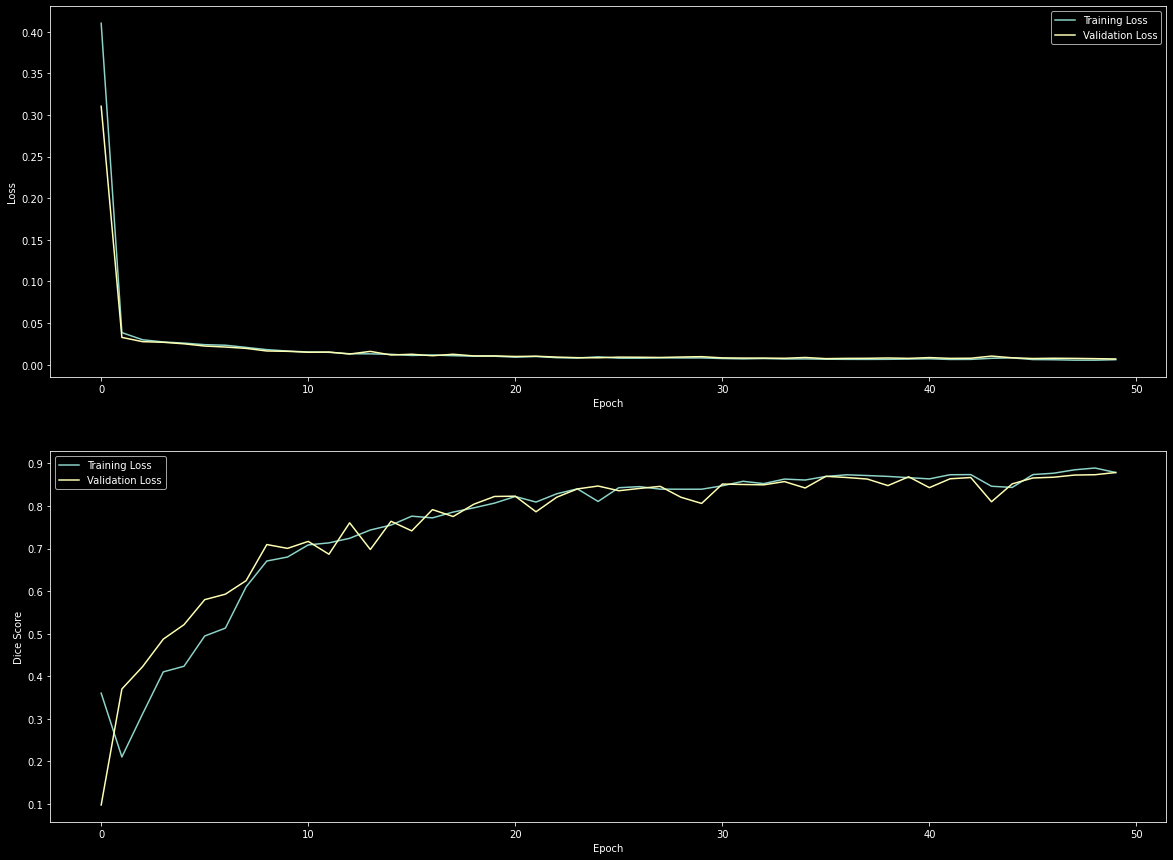

In [33]:
fig = plt.figure(figsize=(20,15))

train_loss = np.array(summary["train_loss"])
valid_loss = np.array(summary["valid_loss"])
dicescore = np.array(summary["train_dice"])
val_dicescore = np.array(summary["valid_dice"])

epochs = range(EPOCHS)

plt.subplot(2, 1, 1)
plt.plot(epochs, train_loss, label="Training Loss")
plt.plot(epochs, valid_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(epochs, dicescore, label="Training Loss")
plt.plot(epochs, val_dicescore, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Dice Score")
plt.legend()

In [34]:
test_loss, test_dice = valid_epoch(test_loader)
print("Test Loss: {}    Dice Score: {}".format(test_loss, test_dice))

  0%|          | 0/11 [00:00<?, ?it/s]

Test Loss: 0.022438840263269165    Dice Score: 0.8790594393556769


In [40]:
torch.save(model, 'normal_model.pth')

In [41]:
torch.save(best_model.state_dict(), 'normal_model_state_dict.pth')

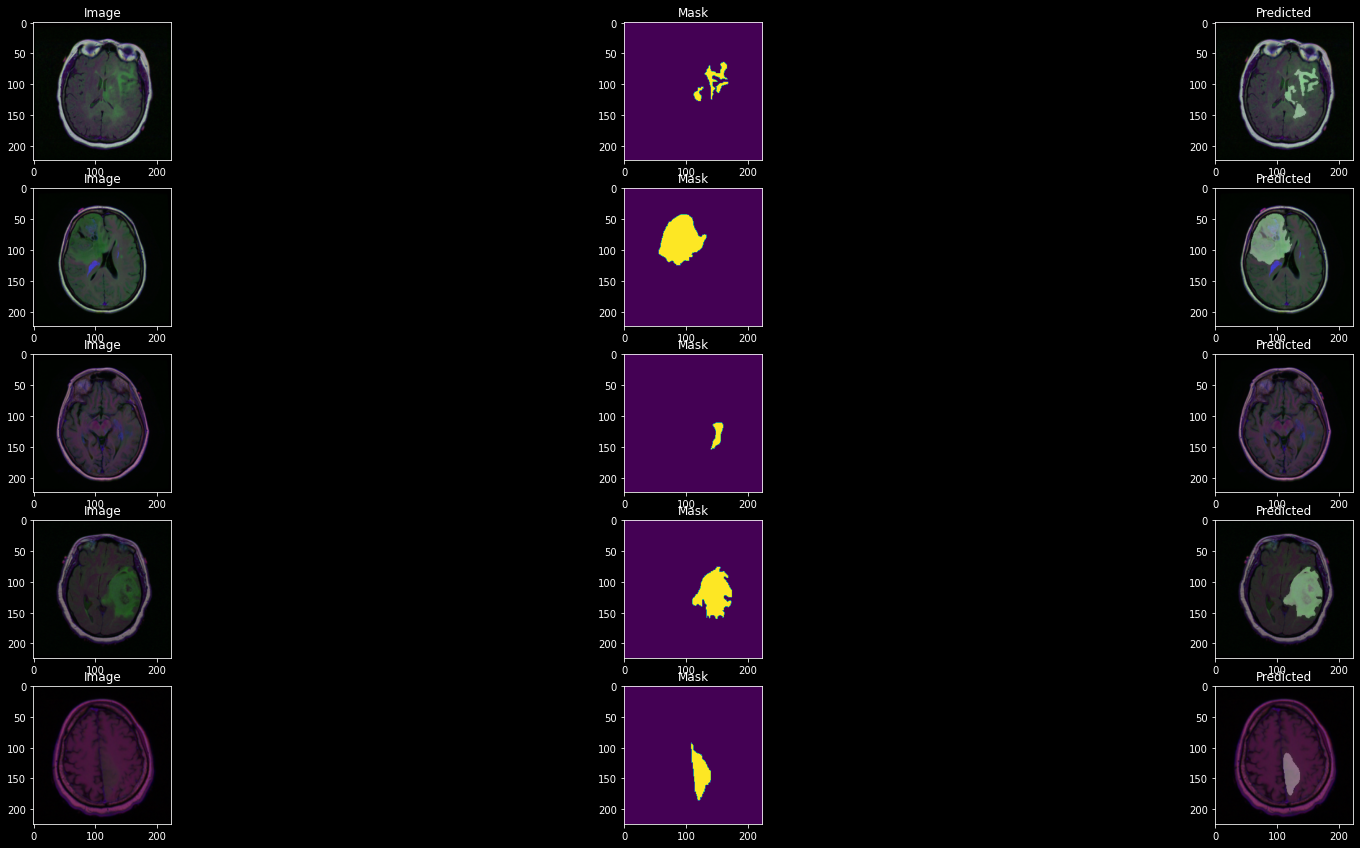

In [39]:
plt.figure(figsize=(30,30))
for i , x in enumerate(test_loader):
    if i==5:
        break
    image, mask = x
    img = image[0].permute(1, 2, 0)
    mask = mask[0].permute(1, 2, 0)
    
    plt.subplot(10, 3, 3*i + 1)
    plt.title("Image")
    plt.imshow(img)
    
    plt.subplot(10, 3, 3*i + 2)
    plt.title("Mask")
    plt.imshow(mask)
    
    image = image.type(torch.FloatTensor).to('cuda')
    predict_mask = model(image)
    predict = torch.sigmoid(predict_mask)
    predict = (predict > 0.5).float()
    
    image_mask = img + predict[0].permute(1,2 , 0).cpu().detach().numpy()*0.3
    
    plt.subplot(10, 3, 3*i + 3)
    plt.title("Predicted")
    plt.imshow(image_mask)